In [2]:
# Dependencies
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#Import data as pandas DF's
Education_2021_df = pd.read_csv("Resources/2021_Education_Postcode.csv")
Income_2021_df = pd.read_csv("Resources/2021_Income_Postcode.csv")
VehicleCount_2021_df = pd.read_csv("Resources/2021_VehicleCount_Postcode.csv")
FuelType_2021_df = pd.read_csv("Resources/FuelType_Postcode.csv")

In [4]:
def create_scatter(df, y_variable, x_variable, colour):

    x_values = df[x_variable]
    y_values = df[y_variable]
    
    ymin = df[y_variable].min()
    xmin = df[x_variable].min()

    ymax = df[y_variable].max()
    xmax = df[x_variable].max()

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(slope) + "x + s" + str(round(intercept,2))

    plt.scatter(
        x_values,
        y_values,
        color = colour,
        marker = 'o',
        s = 50,
        edgecolors = 'black')

    plt.plot(x_values, regress_values, "r-", linewidth = 1)

    plt.xlabel(x_variable)
    plt.ylabel(y_variable)
    plt.suptitle(f"The r-value is: {rvalue}", fontsize = 8, x = 0.2, y = 0.95)
    plt.annotate(line_eq, xy=(0.5, 1.05), fontsize =8, color = "red",
            xycoords='axes fraction', textcoords='axes fraction')

    plt.show()


In [5]:
def reshape_df(df):
    return df.pivot_table(index = ['Vehicle_type', 'Postcode'], 
                          columns = 'Fuel_type', 
                          values = 'Count').reset_index().rename_axis(None, axis=1)

In [6]:
def clean_headers(df):
    df.columns = df.columns.str.replace(" ", "_")
    return df

Clean Data

In [7]:
#Clean Headers
Education_2021_df = clean_headers(Education_2021_df)
Income_2021_df = clean_headers(Income_2021_df)
VehicleCount_2021_df = clean_headers(VehicleCount_2021_df)
FuelType_2021_df = clean_headers(FuelType_2021_df)

In [8]:
FuelType_2021_df = reshape_df(FuelType_2021_df)

In [9]:
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Vehicle_type"] != "Total"]
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Postcode"] != "Total"]

c:\Users\joshm\anaconda3\envs\PythonData\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Merge DFs so that Education, income, vehicle count, fuel type are in 1 df on postcode handle different postcodes that arent present in all datasets

In [10]:
Education_2021_df['Postcode'] = Education_2021_df['Postcode'].astype(int)
data_education_income_2021 = pd.merge(Education_2021_df, Income_2021_df, how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = pd.merge(data_education_income_2021, VehicleCount_2021_df ,how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = data_complete_2021.drop(['State','Total_y', 'Total'], axis=1)

Remove data for "Not Stated or Not Applicable" and subtract from Total column

In [11]:
Education_2021_df["Total"] = Education_2021_df["Total"] - (Education_2021_df["Not_stated"] + Education_2021_df["Not_applicable"])
Education_2021_df = Education_2021_df.drop(columns=["Not_stated", "Not_applicable"])


In [12]:
Income_2021_df["Total"] = Income_2021_df["Total"] - (Income_2021_df["Not_stated"] + Income_2021_df["Not_applicable"])
Income_2021_df = Income_2021_df.drop(columns=["Not_stated", "Not_applicable"])

Create DF's with normalised values (percentage of total)

In [13]:
Education_2021_Normalized = Education_2021_df.copy()
for col in Education_2021_Normalized.columns[2:-1]:
    Education_2021_Normalized[col] = Education_2021_Normalized[col] / Education_2021_Normalized["Total"] * 100
Education_2021_Normalized = Education_2021_Normalized.round(2)

In [14]:
FuelType_2021_Normalized = FuelType_2021_df.copy()
for col in FuelType_2021_Normalized.columns[2:-1]:
    FuelType_2021_Normalized[col] = FuelType_2021_Normalized[col] / FuelType_2021_Normalized["Total"] * 100
FuelType_2021_Normalized = FuelType_2021_Normalized.round(2)

In [15]:
Income_2021_Normalized = Income_2021_df.copy()
for col in Income_2021_Normalized.columns[2:-1]:
    Income_2021_Normalized[col] = Income_2021_Normalized[col] / Income_2021_Normalized["Total"] * 100
Income_2021_Normalized = Income_2021_Normalized.round(2)

Group into bigger bins for simplicity of plotting.
Make new dfs with created bins

In [16]:
#Calculate an "Income score" for each 
def calculate_income_score(row):
    values = row[2:-2].values
    weights = [0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    weighted_sum = sum([value * weight for value, weight in zip(values, weights)])
    
    return weighted_sum

Income_2021_Normalized['Income_Score'] = Income_2021_Normalized.apply(calculate_income_score, axis=1)

In [17]:
Education_2021_Scored = Education_2021_Normalized
#Apply a multiplier based on education score to new columns
Education_2021_Scored["Postgraduate_Degree_Score"] = Education_2021_Scored["Postgraduate_Degree_Level"].apply(lambda x: x*7)
Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Score"] = Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Level"].apply(lambda x: x*6)
Education_2021_Scored["Bachelor_Degree_Score"] = Education_2021_Scored["Bachelor_Degree_Level"].apply(lambda x: x*5)
Education_2021_Scored["Advanced_Diploma_and_Diploma_Score"] = Education_2021_Scored["Advanced_Diploma_and_Diploma_Level"].apply(lambda x: x*4)
Education_2021_Scored["Certificate_III_&_IV_Level_Score"] = Education_2021_Scored["Certificate_III_&_IV_Level"].apply(lambda x: x*3)
Education_2021_Scored["Certificate_I_&_II_Level_Score"] = Education_2021_Scored["Certificate_I_&_II_Level"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_10_and_above_Score"] = Education_2021_Scored["Secondary_Education_-_Years_10_and_above"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_9_and_below_Score"] = Education_2021_Scored["Secondary_Education_-_Years_9_and_below"].apply(lambda x: x*1)
#Drop unneeeded columns
Education_2021_Scored = Education_2021_Scored.drop(["Postgraduate_Degree_Level", "Graduate_Diploma_and_Graduate_Certificate_Level", "Bachelor_Degree_Level", "Advanced_Diploma_and_Diploma_Level", "Certificate_III_&_IV_Level", "Certificate_I_&_II_Level", "Secondary_Education_-_Years_10_and_above", "Secondary_Education_-_Years_9_and_below"], axis=1)
#Create a column in df with summed education scores
Education_Score_List = ["Postgraduate_Degree_Score", "Graduate_Diploma_and_Graduate_Certificate_Score", "Bachelor_Degree_Score", "Advanced_Diploma_and_Diploma_Score", "Certificate_III_&_IV_Level_Score", "Certificate_I_&_II_Level_Score", "Secondary_Education_-_Years_10_and_above_Score", "Secondary_Education_-_Years_9_and_below_Score"]
Education_2021_Scored["Education_Score"] = Education_2021_Scored[Education_Score_List].sum(axis=1)


Merge Education and Income tables with fuel types, Then remove suburbs where no fuel types were recorded to disregard NaN values.

In [18]:
Income_Fueltype_2021 = pd.merge(FuelType_2021_Normalized, Income_2021_Normalized, on='Postcode')
Income_Fueltype_2021 = Income_Fueltype_2021[Income_Fueltype_2021['Total_x'] != 0]
Income_Fueltype_2021 = Income_Fueltype_2021[Income_Fueltype_2021['Vehicle_type'] == "Passenger Vehicles"]

In [19]:
Education_Fueltype_2021 = pd.merge(FuelType_2021_Normalized, Education_2021_Scored, on = "Postcode")
Education_Fueltype_2021 = Education_Fueltype_2021[Education_Fueltype_2021['Total_x'] != 0]

#Select only Passenger Vehicles
Education_Fueltype_2021 = Education_Fueltype_2021[Education_Fueltype_2021['Vehicle_type'] == "Passenger Vehicles"]
Education_Fueltype_2021


,Vehicle_type,Postcode,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total_x,State,...,Total_y,Postgraduate_Degree_Score,Graduate_Diploma_and_Graduate_Certificate_Score,Bachelor_Degree_Score,Advanced_Diploma_and_Diploma_Score,Certificate_III_&_IV_Level_Score,Certificate_I_&_II_Level_Score,Secondary_Education_-_Years_10_and_above_Score,Secondary_Education_-_Years_9_and_below_Score,Education_Score
1,Passenger Vehicles,800,19.65,0.06,0.19,0.0,0.0,80.00,5196,NT,...,5645,109.34,19.86,146.15,47.12,38.04,0.00,45.20,2.30,408.01
3,Passenger Vehicles,810,14.54,0.03,0.21,0.0,0.0,85.21,17454,NT,...,24800,86.31,23.64,115.35,36.48,45.42,0.24,54.12,6.04,367.60
5,Passenger Vehicles,812,15.14,0.03,0.32,0.0,0.0,84.57,9077,NT,...,12992,37.38,17.34,78.65,37.76,58.74,0.36,71.22,7.58,309.03
7,Passenger Vehicles,820,20.90,0.08,0.24,0.0,0.0,78.79,14127,NT,...,15089,79.31,24.72,127.80,42.56,48.00,0.24,50.46,4.13,377.22
9,Passenger Vehicles,822,35.89,0.00,0.58,0.0,0.0,63.56,3452,NT,...,16634,10.29,5.94,24.45,15.36,34.89,0.86,106.58,19.30,217.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,Passenger Vehicles,7466,16.67,0.00,0.00,0.0,0.0,100.00,18,TAS,...,24,0.00,0.00,0.00,0.00,37.50,0.00,91.66,16.67,145.83
5273,Passenger Vehicles,7467,13.33,0.00,0.37,0.0,0.0,85.74,1073,TAS,...,1307,16.10,5.94,39.80,21.72,74.37,0.00,91.04,10.41,259.38
5275,Passenger Vehicles,7468,21.50,0.00,0.00,0.0,0.0,79.25,400,TAS,...,501,25.13,10.80,44.90,34.32,85.02,0.00,71.06,9.38,280.61
5277,Passenger Vehicles,7469,19.36,0.00,0.60,0.0,0.0,78.44,501,TAS,...,559,10.01,0.00,34.90,27.20,85.86,0.00,72.62,17.89,248.48


In [20]:
# read in and add electoraterating values for each postcode. Remove duplicates and keep the first non-null value for electoraterating
# Outer Metro, Inner Metro and provincial are grouped for this purpose as "Metro", and Rural is left as Rural. Null values will be dropped for the purpose of plotting.
Metro_Rural_Postcode = pd.read_csv('Resources/ElectorateRating_Postcode.csv')
Metro_Rural_Postcode = Metro_Rural_Postcode.drop_duplicates().groupby('Postcode', as_index=False).first()

In [21]:
#Merge Metro/Rural values with Income and Education dfs
Education_Fueltype_2021 = pd.merge(Education_Fueltype_2021, Metro_Rural_Postcode, on = "Postcode")
Income_Fueltype_2021 = pd.merge(Income_Fueltype_2021, Metro_Rural_Postcode, on='Postcode')

In [22]:
#Drop Rows where Metro_Rural is NaN
Education_Fueltype_2021.dropna(subset=["Metro_Rural"], inplace=True)
Income_Fueltype_2021.dropna(subset=["Metro_Rural"], inplace=True)

In [23]:
Income_Fueltype_2021.sort_values("Electric", ascending = False)

,Vehicle_type,Postcode,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total_x,State,...,"$1,000-$1,249_($52,000-$64,999)","$1,250-$1,499_($65,000-$77,999)","$1,500-$1,749_($78,000-$90,999)","$1,750-$1,999_($91,000-$103,999)","$2,000-$2,999_($104,000-$155,999)","$3,000-$3,499_($156,000-$181,999)","$3,500_or_more_($182,000_or_more)",Total_y,Income_Score,Metro_Rural
691,Passenger Vehicles,3026,14.38,10.12,1.53,0.0,0.00,73.88,4652,VIC,...,11.33,9.14,7.05,5.23,6.95,1.35,1.15,5930,593.40,Rural
2411,Passenger Vehicles,6462,25.81,9.68,0.00,0.0,0.00,70.97,31,WA,...,6.36,4.55,10.00,4.55,10.91,0.00,2.73,110,612.79,Rural
268,Passenger Vehicles,2308,8.28,3.82,0.00,0.0,1.91,85.35,157,NSW,...,0.94,0.00,0.00,0.00,0.00,0.00,0.31,957,251.73,Rural
473,Passenger Vehicles,2609,15.95,3.35,0.26,0.0,17.13,63.16,4927,ACT,...,15.23,9.30,6.06,3.50,4.99,1.21,1.89,742,610.96,Metro
879,Passenger Vehicles,3237,28.14,1.80,5.99,0.0,0.00,69.46,167,VIC,...,11.82,3.94,6.40,3.94,0.00,0.00,1.97,203,502.86,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,Passenger Vehicles,4492,68.15,0.00,2.22,0.0,2.22,35.56,135,QLD,...,15.98,7.38,7.38,3.28,9.02,4.10,2.87,244,704.64,Rural
1595,Passenger Vehicles,4491,42.11,0.00,0.00,0.0,0.00,65.79,38,QLD,...,9.64,10.84,10.84,6.02,0.00,0.00,0.00,83,585.43,Rural
1594,Passenger Vehicles,4490,29.60,0.00,0.44,0.0,0.44,69.66,679,QLD,...,8.50,6.73,5.33,2.43,4.49,0.84,1.50,1070,533.42,Rural
1593,Passenger Vehicles,4489,50.00,0.00,0.00,0.0,7.14,52.38,42,QLD,...,5.17,6.90,0.00,0.00,8.62,8.62,0.00,58,668.90,Rural


Create Plots

All values Scatter

In [24]:
Income_Metro = Income_Fueltype_2021[Income_Fueltype_2021['Metro_Rural'] == 'Metro']
Education_Metro = Education_Fueltype_2021[Education_Fueltype_2021['Metro_Rural'] == 'Metro']
Income_Rural= Income_Fueltype_2021[Income_Fueltype_2021['Metro_Rural'] == 'Rural']
Education_Rural = Education_Fueltype_2021[Education_Fueltype_2021['Metro_Rural'] == 'Rural']

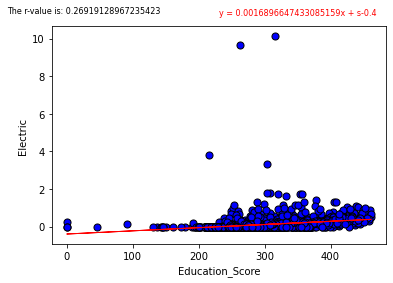

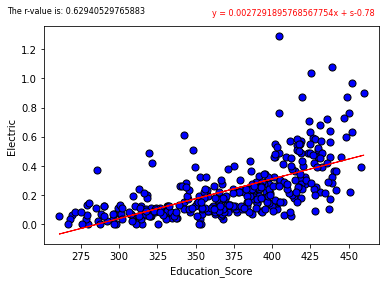

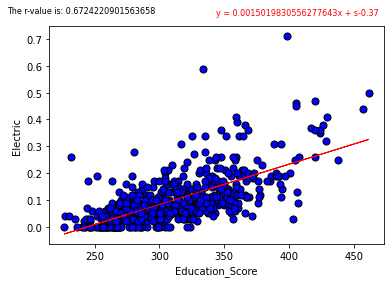

In [28]:
create_scatter(Education_Fueltype_2021, "Electric", "Education_Score", "blue")
create_scatter(Education_Metro.query("Total_x > 5000"), "Electric", "Education_Score", "blue")
create_scatter(Education_Rural.query("Total_x > 5000"), "Electric", "Education_Score", "blue")

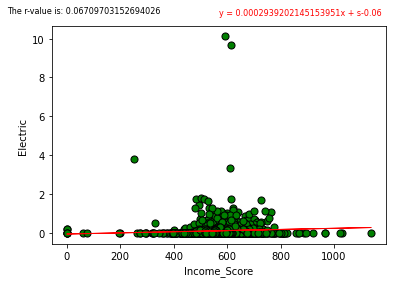

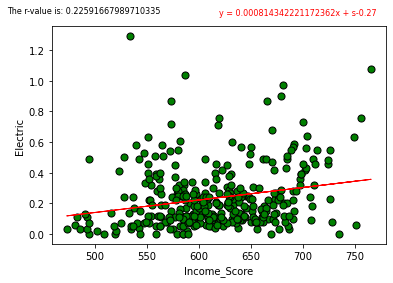

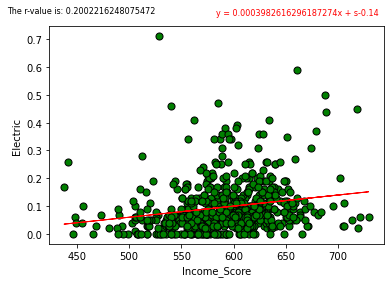

In [27]:
create_scatter(Income_Fueltype_2021, "Electric", "Income_Score", "green")
create_scatter(Income_Metro.query("Total_x > 5000"), "Electric", "Income_Score", "green")
create_scatter(Income_Rural.query("Total_x > 5000"), "Electric", "Income_Score", "green")

In [ ]:
Income_Metro_Max = Income_Metro.query("Total_x > 5000").sort_values("Income_Score", ascending = False).head(3)
Income_Metro_Min = Income_Metro.query("Total_x > 5000").sort_values("Income_Score", ascending = False).tail(3)

In [ ]:
Education_Metro_Max = Education_Metro.query("Total_x > 5000").sort_values("Education_Score", ascending = False).head(3)
Education_Metro_Min = Education_Metro.query("Total_x > 5000").sort_values("Education_Score", ascending = False).tail(3)